In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import sqlite3
from sklearn import svm
from sklearn.model_selection import cross_val_score, LeaveOneOut, train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import os
sns.set()

In [2]:
# load data from untap
conn = sqlite3.connect('/home/kfang/one_hot_blood_type/untap.db')
c = conn.cursor()
c.execute('SELECT * FROM demographics')
rows = c.fetchall()
colnames = [i[0] for i in c.description]
data = pd.DataFrame(rows, columns=colnames)
conn.close()

In [3]:
dataBloodType = data[['human_id', 'blood_type']]
dataBloodType = dataBloodType.replace('', np.nan, inplace=False)
dataBloodType = dataBloodType.dropna(axis=0, how='any', inplace=False)

# Creating dummy variables for A, B and rh factor
dataBloodType['A'] = dataBloodType['blood_type'].str.contains('A',na=False).astype(int)
dataBloodType['B'] = dataBloodType['blood_type'].str.contains('B',na=False).astype(int)
dataBloodType['Rh'] = dataBloodType['blood_type'].str.contains('\+',na=False).astype(int)

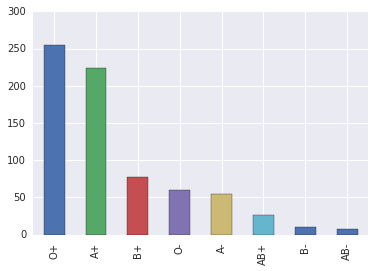

In [4]:
dataBloodType['blood_type'].value_counts().plot(kind='bar')

In [5]:
# function to retrieve a tile file from keep
tiled_data_dir = "/home/kfang/keep/by_id/su92l-4zz18-b8rs5x7t6gry16k/"
def get_file(name, np_file = True):
    if np_file: 
        return np.load(os.path.join(tiled_data_dir, name))
    else:
        return open(os.path.join(tiled_data_dir, name), 'r')

In [6]:
Xtrain = np.load('./all.npy')
path_data = np.load('./all-info.npy')

In [7]:
Xtrain += 2

In [8]:
names_file = get_file("names.npy", np_file = False)
names = []
for line in names_file:
    names.append(line[45:54][:-1])

In [9]:
# Getting phenotypes for huIDs that have associated genotypes

results = [i.lower() for i in names]

df = pd.DataFrame(results,columns={'Sample'})
df['Number'] = df.index

In [10]:
dataBloodType = data[['human_id', 'blood_type']]
dataBloodType = dataBloodType.replace('', np.nan, inplace=False)
dataBloodType = dataBloodType.dropna(axis=0, how='any', inplace=False)

# Creating dummy variables for A, B and rh factor
dataBloodType['A'] = dataBloodType['blood_type'].str.contains('A',na=False).astype(int)
dataBloodType['B'] = dataBloodType['blood_type'].str.contains('B',na=False).astype(int)
dataBloodType['Rh'] = dataBloodType['blood_type'].str.contains('\+',na=False).astype(int)

In [11]:
dataBloodType.human_id = dataBloodType.human_id.str.lower()
df2 = df.merge(dataBloodType,left_on = 'Sample', right_on='human_id', how='inner')
del dataBloodType
#df2

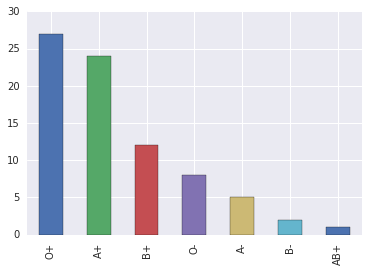

In [12]:
df2['blood_type'].value_counts().plot(kind='bar')

In [13]:
df2['blood_type'].value_counts()
del df

In [14]:
# Get genotypes that have associated blood type phenotype
idx = df2['Number'].values

Xtrain = Xtrain[idx,:] 
Xtrain.shape

(79, 21310012)

In [15]:
# Remove tiles (columns) that don't have more than 1 tile varient at every position
# Actually probably will want to technically do this before the one-hot, so I am keeping these in for the moment

min_indicator = np.amin(Xtrain, axis=0)
max_indicator = np.amax(Xtrain, axis=0)

sameTile = min_indicator == max_indicator
skipTile = ~sameTile

idxOP = np.arange(Xtrain.shape[1])
Xtrain = Xtrain[:, skipTile]
newPaths = path_data[skipTile]
idxOP = idxOP[skipTile]

Xtrain.shape

(79, 18519161)

In [16]:
# only keep data with less than 10% missing data
nnz = np.count_nonzero(Xtrain, axis=0)
fracnnz = np.divide(nnz.astype(float), Xtrain.shape[0])

idxKeep = fracnnz >= 0.9
Xtrain = Xtrain[:, idxKeep]

In [17]:
y = df2.A.values

In [18]:
# save information about deleting missing/spanning data
varvals = np.full(50 * Xtrain.shape[1], np.nan)
nx = 0

varlist = []
for j in range(0, Xtrain.shape[1]):
    u = np.unique(Xtrain[:,j])
    varvals[nx : nx + u.size] = u
    nx = nx + u.size
    varlist.append(u)

varvals = varvals[~np.isnan(varvals)]

print(varvals.shape)
np.save("./npy_data/varvals.npy", varvals)

(36399562,)


In [19]:
def foo(col):
    u = np.unique(col)
    nunq = u.shape
    return nunq

invals = np.apply_along_axis(foo, 0, Xtrain)
invals = invals[0]

In [20]:
# used later to find coefPaths
pathdataOH = np.repeat(newPaths[idxKeep], invals)
# used later to find the original location of the path from non one hot
oldpath = np.repeat(idxOP[idxKeep], invals)

In [21]:
np.save("./npy_data/idx_keep.npy", idxKeep)
np.save("./npy_data/path_data_oh.npy", pathdataOH)
np.save("./npy_data/old_path.npy", oldpath)

In [22]:
np.save("./npy_data/train_data.npy", Xtrain)

In [23]:
np.save("./npy_data/blood_types.npy", y)

In [24]:
np.save('./npy_data/path_data.npy', newPaths)

In [26]:
# a Jupyter thing to send the encoding to Arvados via CWL.
!arvados-cwl-runner --name "Encode Blood Types" --api containers  encode.cwl --arr npy_data/train_data.npy --script just_encode.py

2018-08-13 15:25:30 cwltool INFO: /usr/bin/arvados-cwl-runner 1.1.4, arvados-python-client 1.1.4, cwltool 1.0.20180403145700
2018-08-13 15:25:30 cwltool INFO: Resolved 'encode.cwl' to 'file:///data-sdc/kfang/one_hot_blood_type/encode.cwl'
2018-08-13 15:25:32 arvados.arv-run INFO: Upload local files: "just_encode.py" "npy_data/train_data.npy"
2018-08-13 15:26:16 arvados.arv-run INFO: Using collection 0e4cda6b136d9e3d1069a8b756ad3445+2618 (su92l-4zz18-98of6jk47evbwbb)
2018-08-13 15:26:44 arvados.cwl-runner INFO: [container Encode Blood Types] su92l-xvhdp-8hmy113y2nel9h3 state is Committed
2018-08-13 15:39:45 arvados.cwl-runner INFO: [container Encode Blood Types] su92l-xvhdp-8hmy113y2nel9h3 is Final
2018-08-13 15:39:45 arvados.cwl-runner INFO: Overall process status is success
2018-08-13 15:39:45 arvados.cwl-runner INFO: Final output collection bfaea5e13d6750e5e30e62dbd91b7593+14520 "Output of encode.cwl" (su92l-4zz18-9b5lg7tckuax1gb)
{
    "enc_out": {
        "basename": "encode_output

In [29]:
!rm npy_data/encoded.npy
!arv-get bfaea5e13d6750e5e30e62dbd91b7593+14520/encoded.npy npy_data/encoded.npy

rm: cannot remove 'npy_data/encoded.npy': No such file or directory
21938 MiB / 21938 MiB 100.0%
